In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import sys
sys.path.append("/Users/bovy/Repos/tgas-completeness/py/")
import tqdm
import numpy
from scipy.stats import skew, skewtest
from extreme_deconvolution import extreme_deconvolution
import gaia_tools.load, gaia_tools.xmatch
from galpy.util import bovy_plot, bovy_coords, save_pickles
import effsel # from tgas-completeness
from effsel import main_sequence_cut_r
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib import gridspec
import copy
save_figures= False
numpy.random.seed(3)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The kinematics of local F stars

Load the TGAS and 2MASS data that we use, among other things, select F-type stars:

In [3]:
# Load TGAS and 2MASS
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

Load the dwarf locus and select TGAS F-type stars with good parallaxes:

In [4]:
# Select F stars
sp= effsel.load_spectral_types()
sptype= 'F'
jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
if sptype == 'M':
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
else:
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
jmin= main_sequence_cut_r(jkmax)
jmax= main_sequence_cut_r(jkmin)
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > 10.)*(jk != 0.)
good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                *(mj < main_sequence_cut_r(jk,tight=False,low=True))\
                *(mj > main_sequence_cut_r(jk,tight=False))
print("Found %i F stars in TGAS with good parallaxes" % (numpy.sum(good_sampling)))
tgas= tgas[good_sampling]
twomass= twomass[good_sampling]
jk= jk[good_sampling]
dm= dm[good_sampling]
mj=mj[good_sampling]

Found 103603 F stars in TGAS with good parallaxes


In [5]:
rave_cat= gaia_tools.load.rave()
m1,m2,sep= gaia_tools.xmatch.xmatch(rave_cat,tgas,colRA1='RAdeg',colDec1='DEdeg',colRA2='ra',colDec2='dec',
                                    epoch1=2000.,epoch2=2015.,swap=True)
rave_cat= rave_cat[m1]
tgas= tgas[m2]
twomass= twomass[m2]
jk= jk[m2]
dm= dm[m2]
mj= mj[m2]
# Exclude stars with |b| <= 25
indx= numpy.fabs(tgas['b']) > 25.
rave_cat= rave_cat[indx]
tgas= tgas[indx]
twomass= twomass[indx]
jk= jk[indx]
dm= dm[indx]
mj= mj[indx]
print("Found %i F stars in TGASxRAVE with good parallaxes" % (len(tgas)))

Found 10509 F stars in TGASxRAVE with good parallaxes


In [6]:
tgas_distance=1.0/tgas['parallax']
tgas_edistance=tgas['parallax_error']/(tgas['parallax']**2)

In [7]:
# Compute XYZUVW for overlap sample
lb= bovy_coords.radec_to_lb(tgas['ra'],tgas['dec'],degree=True,epoch=None)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],tgas_distance,degree=True)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(tgas['pmra'],tgas['pmdec'],
                                          tgas['ra'],tgas['dec'],degree=True,epoch=None)
vxyz= bovy_coords.vrpmllpmbb_to_vxvyvz(rave_cat['HRV'],pmllbb[:,0],pmllbb[:,1],
                                       XYZ[:,0],XYZ[:,1],XYZ[:,2],
                                       XYZ=True,degree=True)

Compute uncertainties on $(v_X,v_Y,v_Y)$ using Monte Carlo sampling of the parallax and proper motion uncertainties (taking into account the correlation matrix):

In [8]:
nmc= 1001
# Need to sample from the (parallax,proper-motion covariance matrix)
plxpm_mc= numpy.empty((len(tgas),3,nmc))
plxpm_mc[:,0,:]= numpy.atleast_2d(tgas['parallax']).T
plxpm_mc[:,1,:]= numpy.atleast_2d(tgas['pmra']).T
plxpm_mc[:,2,:]= numpy.atleast_2d(tgas['pmdec']).T
for ii in range(len(tgas)):
    # Construct covariance matrixx
    tcov= numpy.zeros((3,3))
    tcov[0,0]= tgas['parallax_error'][ii]**2./2. # /2 because of symmetrization below
    tcov[1,1]= tgas['pmra_error'][ii]**2./2.
    tcov[2,2]= tgas['pmdec_error'][ii]**2./2.
    tcov[0,1]= tgas['parallax_pmra_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmra_error'][ii]
    tcov[0,2]= tgas['parallax_pmdec_corr'][ii]*tgas['parallax_error'][ii]*tgas['pmdec_error'][ii]
    tcov[1,2]= tgas['pmra_pmdec_corr'][ii]*tgas['pmra_error'][ii]*tgas['pmdec_error'][ii]
    # symmetrize
    tcov= (tcov+tcov.T)
    # Cholesky decomp.
    L= numpy.linalg.cholesky(tcov)
    plxpm_mc[ii]+= numpy.dot(L,numpy.random.normal(size=(3,nmc)))

In [9]:
lbtile= numpy.tile(lb,(nmc,1))
XYZ_sam= bovy_coords.lbd_to_XYZ(lbtile[:,0],lbtile[:,1],(1./plxpm_mc[:,0,:]).T.flatten(),degree=True)
ratile= numpy.tile(tgas['ra'],(nmc,1)).flatten()
dectile= numpy.tile(tgas['dec'],(nmc,1)).flatten()
pmllbb_sam= bovy_coords.pmrapmdec_to_pmllpmbb(plxpm_mc[:,1,:].T.flatten(),plxpm_mc[:,2,:].T.flatten(),
                                              ratile,dectile,degree=True,epoch=None)
vxyz_sam= bovy_coords.vrpmllpmbb_to_vxvyvz((numpy.atleast_2d(rave_cat['HRV']).T\
                                               +numpy.random.normal(size=nmc)\
                                               *numpy.atleast_2d(rave_cat['eHRV']).T).T.flatten(),
                                           pmllbb_sam[:,0],pmllbb_sam[:,1],
                                           XYZ_sam[:,0],XYZ_sam[:,1],XYZ_sam[:,2],
                                           XYZ=True,degree=True)
vxyz_sam= vxyz_sam.reshape((nmc,len(tgas),3))
vxyz_err= numpy.std(vxyz_sam,axis=0)
vxyz_mean= numpy.mean(vxyz_sam,axis=0)
vxyz_skew= skewtest(vxyz_sam[:,:,2],axis=0) #vxyz_skew[1] = P(Gaussian, not skewed)

A comparison between the MC samples and the Gaussian approximation for two stars...

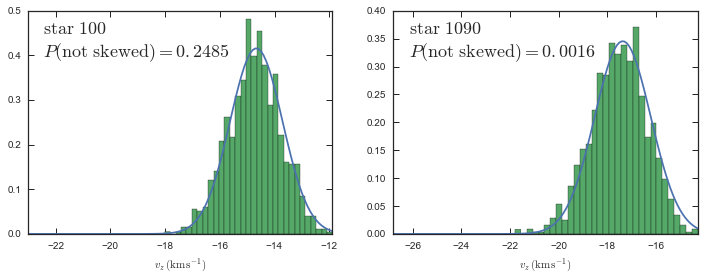

In [10]:
figsize(12,4)
subplot(1,2,1)
ii= 100
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.exp(-0.5*(xs-vxyz[ii,2])**2./vxyz_err[ii,2]**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)
_= hist(vxyz_sam[:,ii,2],bins=31,normed=True)
xlim(numpy.amin(vxyz_sam[:,ii,2])-5.,numpy.amax(vxyz_sam[:,ii,2]))
bovy_plot.bovy_text(r'$\mathrm{star\ %i}$' % ii +'\n'
                    +r'$P(\mathrm{not\ skewed}) = %.4f$' % (skewtest(vxyz_sam[:,ii,2])[1]),top_left=True,size=18.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
subplot(1,2,2)
ii= 1090
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.exp(-0.5*(xs-vxyz[ii,2])**2./vxyz_err[ii,2]**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)
_= hist(vxyz_sam[:,ii,2],bins=31,normed=True)
xlim(numpy.amin(vxyz_sam[:,ii,2])-5.,numpy.amax(vxyz_sam[:,ii,2]))
bovy_plot.bovy_text(r'$\mathrm{star\ %i}$' % ii +'\n'
                    +r'$P(\mathrm{not\ skewed}) = %.4f$' % (skewtest(vxyz_sam[:,ii,2])[1]),top_left=True,size=18.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

The distribution of uncertainties in $v_z$ is:

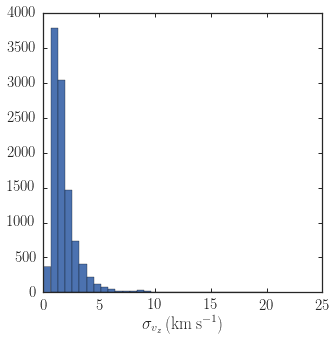

In [11]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
_= hist(vxyz_err[:,2],bins=31,range=[0.,20.])
xlabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The vertical velocity distribution is:

Selecting 4884 out of 10509 stars for vz fit
('lnL, symmetric', -4.0830536659454415)
('Combined <v^2>, sqrt(<v^2>):', 184.75698511243436, 13.592534168154016)
('lnL', -4.082154534579293)
('amp, mean, std. dev.', array([ 0.00730834,  0.23386283,  0.75882883]), array([-117.90974245,   -8.05058806,   -5.87151268]), array([ 373.90660343,   20.77706234,   10.37103154]))
('Combined <v^2>, sqrt(<v^2>):', 184.77296118816511, 13.593121833786569)


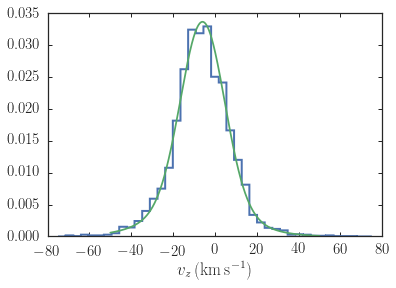

In [14]:
figsize(6,4)
indx= (True-numpy.any(numpy.isnan(vxyz),axis=1))\
    *(numpy.fabs(XYZ[:,2]) < .4)\
    *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)\
    *(True-numpy.isnan(vxyz_err[:,2]))\
    *(vxyz_skew[1] > 0.05)
print("Selecting %i out of %i stars for vz fit" % (numpy.sum(indx),len(tgas)))
_= bovy_plot.bovy_hist(vxyz[indx,2],bins=41,range=[-75.,75.],
                       histtype='step',lw=2.,normed=True,overplot=True)
# Fit with mix of Gaussians
ydata= numpy.atleast_2d(vxyz[indx,2]).T
ycovar= vxyz_err[indx,2]**2.
ngauss= 3
initamp= numpy.random.uniform(size=ngauss)
initamp/= numpy.sum(initamp)
m= numpy.median(vxyz[indx,2])
s= 1.4826*numpy.median(numpy.fabs(vxyz[indx,2]-m))
initmean= []
initcovar= []
# Symmetric fit first, fix means to be the same at ~good value
for ii in range(ngauss):
    initcovar.append(4.*s**2.)
initcovar= numpy.array([[initcovar]]).T
initmean= numpy.array([[-6.4 for ii in range(ngauss)]]).T
print("lnL, symmetric",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar,fixmean=True))
print("Combined <v^2>, sqrt(<v^2>):",combined_sig2(initamp,initmean[:,0],initcovar[:,0,0]),
      numpy.sqrt(combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])))
# Now let the means vary
initmean= []
for ii in range(ngauss):
    initmean.append(m+numpy.random.normal()*s)
initmean= numpy.array([initmean]).T
print("lnL",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar))
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.sum(numpy.atleast_2d(initamp/numpy.sqrt(initcovar[:,0,0])).T\
              *numpy.exp(-0.5*(xs-numpy.atleast_2d(initmean[:,0]).T)**2./numpy.atleast_2d(initcovar[:,0,0]).T),axis=0)\
            /numpy.sqrt(2.*numpy.pi)
plot(xs,ys)
print("amp, mean, std. dev.",initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
def combined_sig2(amp,mean,covar):
    indx= numpy.sqrt(covar) < 30.
    tamp= amp[indx]/numpy.sum(amp[indx])
    return (numpy.sum(tamp*(covar+mean**2.)[indx])-numpy.sum(tamp*mean[indx])**2.)
print("Combined <v^2>, sqrt(<v^2>):",combined_sig2(initamp,initmean[:,0],initcovar[:,0,0]),
      numpy.sqrt(combined_sig2(initamp,initmean[:,0],initcovar[:,0,0])))
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

The distribution of $(v_z,\sigma_{v_z})$:

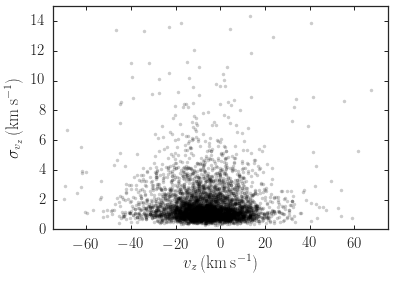

In [15]:
plot(vxyz[indx,2],vxyz_err[indx,2],'k.',alpha=0.2)
xlim(-75.,75.)
ylim(0.,15.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
ylabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The $(z,v_z)$ distribution for this sample:

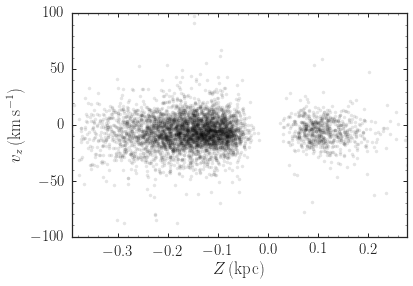

In [16]:
bovy_plot.bovy_plot(XYZ[indx,2],vxyz[indx,2],'k.',alpha=0.1,
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$v_z\,(\mathrm{km\,s}^{-1})$')